# Territorial Expansion of Portuguese Goa (1510–1961)

We will render a map showing Portuguese territorial expansion in Goa. Each district colored by the moment it was acquired. Turns out the Indian government has a very useful geographic API that we will be using!

**Data sources:**
- Goa district polygons: [geo.nic.in](https://geo.nic.in) API service

In [1]:
import json
from pathlib import Path

import geopandas as gpd
import matplotlib.patheffects as pe
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import requests
from shapely.geometry import box, LineString

%matplotlib inline

## Data paths & URLs

All geographic data comes from NIC (National Informatics Centre) services.
Goa districts from `geo.nic.in`, neighboring state boundaries from `webgis1.nic.in`.
Both use EPSG:4326 and share the same boundary precision, so edges align perfectly.

In [2]:
CACHE_DIR = Path("cache")

GOA_API_URL = ("https://geo.nic.in/server/rest/services/goa/gsuda/MapServer/26/query"
               "?where=1%3D1&outFields=*&outSR=4326&f=geojson")

NEIGHBOR_STATE_URL = ("https://webgis1.nic.in/publishing/rest/services/"
                      "BharatMapService/State_Boundary/MapServer/0/query"
                      "?where=stname%3D%27{state}%27&outFields=*&outSR=4326&f=geojson")

## Historical context

Portuguese expansion into Goa happened in four main waves. In 1510, Afonso de Albuquerque seized the island of Goa from the Bijapur Sultanate. In the 1700s, observing fragility in the Indian continent, some other districts were absorbed into Portuguese administration. Information below was recorded from Wikipedia.

| Year | Districts acquired |
|------|------------------|
| **1510** | Afonso de Albuquerque seizes the island of Goa from the Bijapur Sultanate. |
| **1543** | Bardez, Salcete & Mormugão annexed from the Bijapur Sultanate. |
| **1763** | Ponda, Sanguem, Quepem, Canacona & Dharbandora annexed from the Maratha Empire. |
| **1788** | Pernem, Bicholim & Satari annexed from the Maratha Empire. |
| **1961** | Annexation of Goa as an Indian separate state, as part of the waves of decolonization. |

In [3]:
STAGES = [{"year": "1510", "label": "Capture of Tiswadi"},
          {"year": "1543", "label": "Velhas Conquistas"},
          {"year": "1763", "label": "Novas Conquistas (S)"},
          {"year": "1788", "label": "Novas Conquistas (N)"},
          {"year": "1961", "label": "Indian Annexation"}]

## District display names

The GeoJSON `sdtname` field holds the district name. Names are used as-is, except one that needed `DISPLAY_FIX`.

In [4]:
DISPLAY_FIX = {"MORMUGAO": "Mormugão"}
NAME_FIELD = "sdtname"

## Colors

Each acquisition stage gets a distinct color. The four stage colors and their legend labels
are used both in the map fill and the legend/timeline strip.

In [5]:
OCEAN, LAND, BORDER, PARCHMENT = "#c6ddf0", "#e8e0d4", "#3d3d3d", "#f5f0e8"
ANNEX_GRAY = "#999999"

STAGE_COLORS = ["#b03a2e", "#c98c1c", "#1e8449", "#2471a3", ANNEX_GRAY]
STAGE_LEGEND = ["1510 — Tiswadi (Ilhas)", "1543 — Old Conquests",
                "1763 — New Conquests (South)", "1788 — New Conquests (North)",
                "1961 — Indian Annexation"]

## Helper functions

In [6]:
def normalize(s):
    return "".join(c for c in str(s).upper() if c.isalpha())

def label_point(geom, n=50):
    minx, miny, maxx, maxy = geom.bounds
    cy = geom.centroid.y
    center_hit = geom.intersection(LineString([(minx - 1, cy), (maxx + 1, cy)]))
    center_w = (center_hit.bounds[2] - center_hit.bounds[0]) if not center_hit.is_empty else 0
    best_cx, best_cy, best_w = geom.centroid.x, cy, center_w
    for i in range(1, n):
        y = miny + (maxy - miny) * i / n
        hit = geom.intersection(LineString([(minx - 1, y), (maxx + 1, y)]))
        if hit.is_empty: continue
        w = hit.bounds[2] - hit.bounds[0]
        if w > best_w:
            best_w, best_cx, best_cy = w, (hit.bounds[0] + hit.bounds[2]) / 2, y
    if best_w >= 1.6 * center_w:
        return best_cx, best_cy
    pt = geom.representative_point()
    return pt.x, pt.y

def fetch_or_cache(url, cache_path):
    CACHE_DIR.mkdir(parents=True, exist_ok=True)
    if cache_path.exists() and cache_path.stat().st_size > 0:
        return json.loads(cache_path.read_text())
    print(f"  downloading {url[:80]}...")
    resp = requests.get(url, timeout=60)
    resp.raise_for_status()
    cache_path.write_text(resp.text)
    return resp.json()

## Data loading

In [7]:
def load_goa_districts():
    geo = fetch_or_cache(GOA_API_URL, CACHE_DIR / "goa_districts.geojson")
    gdf = gpd.GeoDataFrame.from_features(geo["features"], crs="EPSG:4326")
    gdf["_norm"] = gdf[NAME_FIELD].map(normalize)
    return gdf

def load_neighbor_states(clip_box):
    frames = []
    for state in ("KARNATAKA", "MAHARASHTRA"):
        geo = fetch_or_cache(NEIGHBOR_STATE_URL.format(state=state),
                             CACHE_DIR / f"{state.lower()}_state.geojson")
        if geo.get("features"):
            g = gpd.GeoDataFrame.from_features(geo["features"], crs="EPSG:4326")
            g.geometry = g.geometry.make_valid()
            frames.append(g)
    if not frames: return gpd.GeoDataFrame()
    return gpd.clip(pd.concat(frames, ignore_index=True), clip_box)

STAGE_MAP = {"TISWADI": 0, "BARDEZ": 1, "SALCETE": 1, "MORMUGAO": 1,
             "PONDA": 2, "SANGUEM": 2, "QUEPEM": 2, "CANACONA": 2, "DHARBANDORA": 2,
             "PERNEM": 3, "BICHOLIM": 3, "SATARI": 3}

## Load data

In [8]:
gdf = load_goa_districts()
b = gdf.total_bounds
pad_x, pad_y = (b[2]-b[0]) * 0.50, (b[3]-b[1]) * 0.18
xmin, xmax = b[0]-pad_x, b[2]+pad_x
ymin, ymax = b[1]-pad_y, b[3]+pad_y

neighbors = load_neighbor_states(box(xmin, ymin, xmax, ymax))
goa_outline = gdf.dissolve()
print(f"Loaded {len(gdf)} districts, {len(neighbors)} neighbor state(s)")

Loaded 12 districts, 2 neighbor state(s)


## Render the map

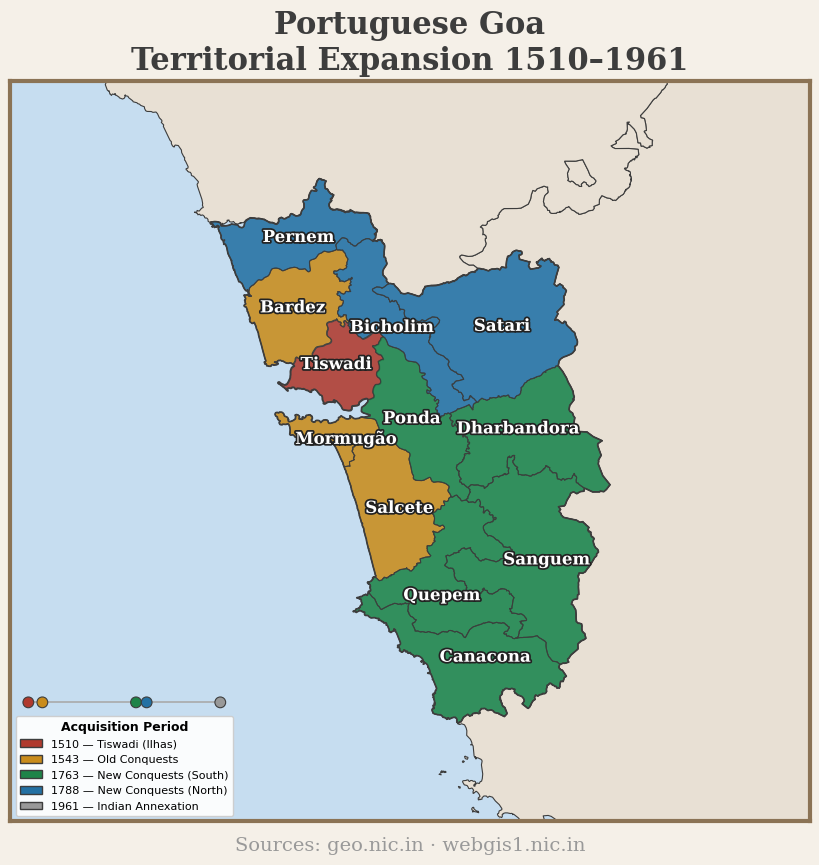

In [9]:
fig, ax = plt.subplots(figsize=(8, 10))
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
fig.patch.set_facecolor(PARCHMENT)
ax.set_facecolor(OCEAN)
ax.set_title("Portuguese Goa\nTerritorial Expansion 1510–1961",
             fontsize=22, fontweight="bold", fontfamily="serif", pad=8, color=BORDER)

# sepia frame
plt.setp(ax.spines.values(), visible=True, edgecolor="#8B7355", linewidth=3)

# land context
if not neighbors.empty:
    neighbors.plot(ax=ax, color=LAND, edgecolor=BORDER, linewidth=0.8)

# districts by stage
gdf["_stage"] = gdf["_norm"].map(STAGE_MAP)
gdf["_display"] = gdf["_norm"].map(lambda n: DISPLAY_FIX.get(n, n.capitalize()))
label_kw = dict(fontsize=12, fontweight="bold", ha="center", va="center",
                color="white", fontfamily="serif",
                path_effects=[pe.withStroke(linewidth=2.5, foreground="#222")])
for si, sub in gdf.dropna(subset="_stage").groupby("_stage"):
    sub.plot(ax=ax, color=STAGE_COLORS[int(si)], edgecolor=BORDER, linewidth=0.8, alpha=0.88)
    for _, row in sub.drop_duplicates("_display").iterrows():
        cx, cy = label_point(row.geometry)
        ax.annotate(row["_display"], (cx, cy), **label_kw)

goa_outline.boundary.plot(ax=ax, color=BORDER, linewidth=1.2)
gdf.boundary.plot(ax=ax, color=BORDER, linewidth=0.4, alpha=0.4)
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax), aspect="equal")
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# legend
handles = [mpatches.Patch(facecolor=c, edgecolor=BORDER, label=l)
           for c, l in zip(STAGE_COLORS, STAGE_LEGEND)]
leg = ax.legend(handles=handles, loc="lower left", fontsize=8, frameon=True, fancybox=True,
                edgecolor="#ccc", facecolor="white", framealpha=0.92,
                title="Acquisition Period", title_fontproperties={"weight": "bold", "size": 9})

# timeline dots
bb = leg.get_window_extent(fig.canvas.get_renderer()).transformed(ax.transAxes.inverted())
ax_tl = ax.inset_axes([bb.x0, bb.y1 + 0.03, bb.width, 0.02])
ax_tl.patch.set_alpha(0)
years = [int(s["year"]) for s in STAGES]
ax_tl.plot([years[0], years[-1]], [0.5, 0.5], color="#aaa", linewidth=1.2, zorder=1)
ax_tl.scatter(years, [0.5] * 5, s=60, c=STAGE_COLORS, edgecolor=BORDER, linewidth=0.8, zorder=3)
ax_tl.set(xlim=(years[0]-30, years[-1]+30), ylim=(-0.5, 1.5))
ax_tl.set_axis_off()

ax.text(0.5, -0.04, "Sources: geo.nic.in · webgis1.nic.in",
        transform=ax.transAxes, ha="center", fontsize=14, fontfamily="serif", color="#999")

plt.show()